# Random Forest Model: Random Forest Regression

Random Forest predicts by ensemble of multiple decision trees, where each tree is trained on randomly sampled data and features:

- **Bagging**: Each tree is trained on bootstrap samples
- **Feature Randomness**: Each tree only considers a random subset of features
- **Non-linear Modeling**: Can capture complex interactions between features

Main Hyperparameters:
- `n_estimators`: Number of trees
- `max_depth`: Maximum depth of trees
- `min_samples_leaf`: Minimum samples in leaf nodes


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
import sys
import os

# Import utility functions
sys.path.append(os.path.dirname(os.path.abspath('')))
from utils import (
    load_data, 
    prepare_features_target, 
    calculate_r2_os, 
    build_portfolio_returns,
    build_portfolio_returns_optimized,
    calculate_prediction_metrics
)
from TimeBasedCV import TimeBasedCV

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


## 1. Load Data


In [2]:
# Load data
df = load_data('ger_factor_data_from2003.csv')

print(f"Data shape: {df.shape}")
print(f"Date range: {df['eom'].min()} to {df['eom'].max()}")
print(f"Number of stocks: {df['id'].nunique()}")

# Prepare features and target
X, y, metadata, feature_names = prepare_features_target(df)
print(f"\nNumber of features: {len(feature_names)}")
print(f"Number of samples: {len(X)}")


Data shape: (604564, 23)
Date range: 2019-01-01 00:00:00 to 2024-11-01 00:00:00
Number of stocks: 13176

Number of features: 16
Number of samples: 604564


## 2. Setup Time Series Cross-Validation


In [3]:
# Create time series cross-validation object
# Adjust based on data length: data is about 6 years, use smaller train/val/test periods
cv = TimeBasedCV(
    train_period=24,   # 2 years training period
    val_period=6,      # 6 months validation period
    test_period=6,     # 6 months test period
    freq='months'
)

# Prepare dataframe for CV
cv_df = metadata.copy()
cv_df['eom'] = pd.to_datetime(cv_df['eom'])

# Set first split date
min_date = cv_df['eom'].min()
max_date = cv_df['eom'].max()
total_months = (max_date.year - min_date.year) * 12 + (max_date.month - min_date.month) + 1
print(f"Total time span: {total_months} months ({min_date.date()} to {max_date.date()})")

first_split_date = (min_date + pd.DateOffset(months=30)).date()
second_split_date = (min_date + pd.DateOffset(months=36)).date()

# Generate cross-validation folds
folds = cv.split(cv_df, first_split_date, second_split_date, date_column='eom', gap=0)

print(f"Generated {len(folds)} cross-validation folds")


Total time span: 71 months (2019-01-01 to 2024-11-01)
Train period: 2019-07-01 - 2021-07-01 ,val period: 2021-07-01 - 2022-01-01 , Test period 2022-01-01 - 2022-07-01 # train records 184419 ,# val records 53091 , # test records 55458
Train period: 2019-10-01 - 2021-10-01 ,val period: 2021-10-01 - 2022-04-01 , Test period 2022-04-01 - 2022-10-01 # train records 188377 ,# val records 54619 , # test records 55511
Train period: 2020-01-01 - 2022-01-01 ,val period: 2022-01-01 - 2022-07-01 , Test period 2022-07-01 - 2023-01-01 # train records 193202 ,# val records 55458 , # test records 55493
Train period: 2020-04-01 - 2022-04-01 ,val period: 2022-04-01 - 2022-10-01 , Test period 2022-10-01 - 2023-04-01 # train records 198473 ,# val records 55511 , # test records 55300
Train period: 2020-07-01 - 2022-07-01 ,val period: 2022-07-01 - 2023-01-01 , Test period 2023-01-01 - 2023-07-01 # train records 203973 ,# val records 55493 , # test records 54766
Train period: 2020-10-01 - 2022-10-01 ,val per

## 3. Define Hyperparameter Search Space (Optimized Version)

**Strategy**: Use coarse-grained search, focusing only on key parameters
- `n_estimators=300`: Fixed, no search (200-500 range is stable enough)
- `max_depth`: Maximum depth of trees, controls complexity
- `max_features`: Number of features to try at each node, controls diversity between trees
- `min_samples_leaf`: Minimum samples in leaf nodes, prevents overfitting

**Optimization**: Only perform parameter calibration on the first fold, then fix parameters for all subsequent folds


In [4]:
# Define hyperparameter grid (coarse-grained search, focusing on key parameters)
# Based on random forest literature and practice, only search the most important parameters
# n_estimators fixed at 300 (200-500 range is stable enough and not too slow)

# Fixed parameters
FIXED_N_ESTIMATORS = 300

# Search parameters (2 values per parameter, total 2×2×2=8 combinations)
param_grid = {
    'max_depth': [8, 12],              # Control tree complexity: 8 (shallower) or 12 (deeper)
    'max_features': ['sqrt', 0.1],      # Control randomness: sqrt (√features) or 10% features
    'min_samples_leaf': [50, 150]       # Prevent overfitting: 50 (more flexible) or 150 (more conservative)
}

# Generate all parameter combinations
all_params = list(ParameterGrid(param_grid))

print(f"✅ Hyperparameter search configuration (coarse-grained)")
print(f"Fixed parameter: n_estimators={FIXED_N_ESTIMATORS}")
print(f"Number of parameter grid combinations: {len(all_params)}")
print(f"\nParameter grid:")
for i, params in enumerate(all_params, 1):
    print(f"  {i}. max_depth={params['max_depth']}, max_features={params['max_features']}, min_samples_leaf={params['min_samples_leaf']}")
print(f"\nStrategy: Only perform parameter search on the first fold, then fix the best parameters for all folds")


✅ Hyperparameter search configuration (coarse-grained)
Fixed parameter: n_estimators=300
Number of parameter grid combinations: 8

Parameter grid:
  1. max_depth=8, max_features=sqrt, min_samples_leaf=50
  2. max_depth=8, max_features=sqrt, min_samples_leaf=150
  3. max_depth=8, max_features=0.1, min_samples_leaf=50
  4. max_depth=8, max_features=0.1, min_samples_leaf=150
  5. max_depth=12, max_features=sqrt, min_samples_leaf=50
  6. max_depth=12, max_features=sqrt, min_samples_leaf=150
  7. max_depth=12, max_features=0.1, min_samples_leaf=50
  8. max_depth=12, max_features=0.1, min_samples_leaf=150

Strategy: Only perform parameter search on the first fold, then fix the best parameters for all folds


## 4. Train Model and Make Predictions (with Hyperparameter Tuning)


In [5]:
# Store all prediction results
all_predictions = []
all_actuals = []
all_dates = []
all_ids = []
best_params_history = []
feature_importances_list = []

# Global best parameters (only search on first fold, then fix)
global_best_params = None

# Train and predict for each fold
for fold_idx, (train_idx, val_idx, test_idx) in enumerate(folds):
    print(f"\nProcessing fold {fold_idx + 1}/{len(folds)}...")
    
    # Prepare training, validation, and test data
    X_train = X.iloc[train_idx].values
    y_train = y.iloc[train_idx].values
    X_val = X.iloc[val_idx].values
    y_val = y.iloc[val_idx].values
    X_test = X.iloc[test_idx].values
    y_test = y.iloc[test_idx].values
    
    # Standardize features (Random Forest usually doesn't need this, but for consistency)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Hyperparameter search: only do once on the first fold
    if fold_idx == 0:
        print(f"  🔍 Performing hyperparameter search on first fold ({len(all_params)} combinations)...")
        best_r2 = -np.inf
        best_params = None
        start_time = pd.Timestamp.now()
        
        for idx, params in enumerate(all_params, 1):
            model = RandomForestRegressor(
                n_estimators=FIXED_N_ESTIMATORS,
                max_depth=params['max_depth'],
                max_features=params['max_features'],
                min_samples_leaf=params['min_samples_leaf'],
                random_state=42,
                n_jobs=-1  # Use all CPU cores
            )
            model.fit(X_train_scaled, y_train)
            y_val_pred = model.predict(X_val_scaled)
            r2_val = calculate_r2_os(y_val, y_val_pred)
            
            if r2_val > best_r2:
                best_r2 = r2_val
                best_params = params.copy()
            
            # Show progress
            if idx % 2 == 0 or idx == len(all_params):
                elapsed = (pd.Timestamp.now() - start_time).total_seconds()
                print(f"    Progress: {idx}/{len(all_params)} ({elapsed:.1f}s, current best R²={best_r2:.4f})", end='\r')
        
        elapsed = (pd.Timestamp.now() - start_time).total_seconds()
        print(f"\n  ✅ Hyperparameter search completed, time: {elapsed:.1f}s")
        print(f"  📌 Best parameters: max_depth={best_params['max_depth']}, max_features={best_params['max_features']}, min_samples_leaf={best_params['min_samples_leaf']}")
        print(f"  📊 Validation R²: {best_r2:.4f}")
        
        # Save global best parameters
        global_best_params = best_params.copy()
        best_params_history.append(global_best_params)
    else:
        # Subsequent folds use fixed best parameters
        print(f"  📌 Using fixed parameters (from first fold search results)")
        best_params = global_best_params
        best_params_history.append(best_params)
    
    # Retrain with best parameters on training+validation set
    X_trainval = np.vstack([X_train_scaled, X_val_scaled])
    y_trainval = np.hstack([y_train, y_val])
    
    best_model = RandomForestRegressor(
        n_estimators=FIXED_N_ESTIMATORS,
        max_depth=best_params['max_depth'],
        max_features=best_params['max_features'],
        min_samples_leaf=best_params['min_samples_leaf'],
        random_state=42,
        n_jobs=-1
    )
    best_model.fit(X_trainval, y_trainval)
    
    # Save feature importances
    feature_importances_list.append(best_model.feature_importances_)
    
    # Predict on test set
    y_pred = best_model.predict(X_test_scaled)
    
    # Save results
    all_predictions.extend(y_pred)
    all_actuals.extend(y_test)
    all_dates.extend(metadata.iloc[test_idx]['eom'].values)
    all_ids.extend(metadata.iloc[test_idx]['id'].values)
    
    # Print fold performance
    r2_fold = calculate_r2_os(y_test, y_pred)
    print(f"  📈 Test R²_OS: {r2_fold:.4f}")

print(f"\n✅ Completed predictions for all folds!")
print(f"Total prediction samples: {len(all_predictions)}")
print(f"\nFixed parameter configuration used:")
print(f"  n_estimators={FIXED_N_ESTIMATORS}")
print(f"  max_depth={global_best_params['max_depth']}")
print(f"  max_features={global_best_params['max_features']}")
print(f"  min_samples_leaf={global_best_params['min_samples_leaf']}")



Processing fold 1/10...
  🔍 Performing hyperparameter search on first fold (8 combinations)...
    Progress: 8/8 (248.4s, current best R²=-0.0801)
  ✅ Hyperparameter search completed, time: 248.4s
  📌 Best parameters: max_depth=12, max_features=sqrt, min_samples_leaf=50
  📊 Validation R²: -0.0801
  📈 Test R²_OS: -0.1123

Processing fold 2/10...
  📌 Using fixed parameters (from first fold search results)
  📈 Test R²_OS: -0.1145

Processing fold 3/10...
  📌 Using fixed parameters (from first fold search results)
  📈 Test R²_OS: -0.0154

Processing fold 4/10...
  📌 Using fixed parameters (from first fold search results)
  📈 Test R²_OS: -0.0107

Processing fold 5/10...
  📌 Using fixed parameters (from first fold search results)
  📈 Test R²_OS: -0.0019

Processing fold 6/10...
  📌 Using fixed parameters (from first fold search results)
  📈 Test R²_OS: -0.0116

Processing fold 7/10...
  📌 Using fixed parameters (from first fold search results)
  📈 Test R²_OS: 0.0102

Processing fold 8/10...

## 5. Calculate Prediction Performance Metrics and Feature Importance


In [6]:
# Calculate overall performance metrics
metrics = calculate_prediction_metrics(all_actuals, all_predictions)

print("=" * 50)
print("Random Forest Model Prediction Performance Metrics")
print("=" * 50)
for key, value in metrics.items():
    if isinstance(value, float):
        print(f"{key:20s}: {value:8.4f}")
    else:
        print(f"{key:20s}: {value}")
print("=" * 50)

# Calculate average feature importance
avg_feature_importance = np.mean(feature_importances_list, axis=0)
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': avg_feature_importance
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance_df.head(20))


Random Forest Model Prediction Performance Metrics
r2_os               :  -0.0198
mse                 :   0.0201
rmse                :   0.1419
mae                 :   0.0925
correlation         :   0.0384
mean_pred           :  -0.0033
mean_true           :  -0.0014
std_pred            :   0.0258
std_true            :   0.1406
n_observations      : 552772

Top 20 Most Important Features:
             feature  importance
5           rvol_21d    0.113777
14    ivol_capm_252d    0.109430
1            ret_6_1    0.091205
0            ret_1_0    0.090097
2           ret_12_1    0.070263
3              chmom    0.069750
4          rmax1_21d    0.064070
12          beta_60m    0.060206
13            betasq    0.058958
7           std_turn    0.055270
15              sic2    0.050663
10      bidaskhl_21d    0.047957
6      turnover_126d    0.043063
11                me    0.037272
8        dolvol_126d    0.037171
9   zero_trades_252d    0.000847


## 6. Build Portfolio and Calculate Returns

### 6.0. Simple Stratification Portfolio (Baseline)


In [7]:
# Build portfolio returns
portfolio_df, summary_stats = build_portfolio_returns(
    all_actuals, 
    all_predictions, 
    all_dates, 
    all_ids, 
    n_deciles=10
)

print("\n" + "=" * 50)
print("Long-Short Portfolio Performance (Random Forest Model)")
print("=" * 50)
for key, value in summary_stats.items():
    if isinstance(value, float):
        print(f"{key:25s}: {value:10.4f}")
    else:
        print(f"{key:25s}: {value}")
print("=" * 50)



Long-Short Portfolio Performance (Random Forest Model)
annual_return            :     0.3963
annual_volatility        :     0.1656
sharpe_ratio             :     2.3930
cumulative_return        :     1.8211
n_months                 : 33
mean_monthly_return      :     0.0330
std_monthly_return       :     0.0478


### 6.1. Optimized Portfolio Construction (Rolling Covariance + Mean-Variance Optimization)

**Professor's Feedback**: The current portfolio formation is "ad-hoc" (stratification). We should:
1. Calculate rolling covariance using empirical or PCA-based methods
2. Use an optimizer with constraints to generate portfolios
3. Try to achieve better performance in some or all cases

**Implementation**:
- **Rolling Covariance**: Calculate covariance matrix using a rolling window (12 months default)
- **Methods**: 
  - Empirical: Direct calculation from historical returns
  - PCA-based: Use Principal Component Analysis to reduce dimensionality before estimating covariance
- **Optimization**: Mean-variance optimization with constraints (risk aversion, max weight per stock, long-only)
- **Comparison**: Compare optimized portfolio vs. simple stratification method


In [8]:
# ============================================================================
# Random Forest Model: Optimized Portfolio Construction
# ============================================================================
print("=" * 70)
print("Random Forest Model: Optimized Portfolio Construction")
print("=" * 70)

# Prepare historical returns data for covariance calculation
historical_returns = pd.DataFrame({
    'date': all_dates,
    'id': all_ids,
    'return': all_actuals
})

print("\nBuilding optimized portfolio using empirical covariance method...")
print("-" * 70)

# Build optimized portfolio using empirical covariance
portfolio_opt_empirical, stats_opt_empirical = build_portfolio_returns_optimized(
    all_actuals,
    all_predictions,
    all_dates,
    all_ids,
    historical_returns_df=historical_returns,
    method='empirical',
    window=12,
    risk_aversion=1.0,
    long_only=True,
    max_weight=0.1,
    n_deciles=10
)

print("\n" + "=" * 70)
print("Optimized Portfolio Performance (Empirical Covariance Method)")
print("=" * 70)
for key, value in stats_opt_empirical.items():
    if isinstance(value, float):
        print(f"{key:25s}: {value:10.4f}")
    else:
        print(f"{key:25s}: {value}")
print("=" * 70)

print("\nBuilding optimized portfolio using PCA-based covariance method...")
print("-" * 70)

# Build optimized portfolio using PCA-based covariance
portfolio_opt_pca, stats_opt_pca = build_portfolio_returns_optimized(
    all_actuals,
    all_predictions,
    all_dates,
    all_ids,
    historical_returns_df=historical_returns,
    method='pca',
    window=12,
    risk_aversion=1.0,
    long_only=True,
    max_weight=0.1,
    n_deciles=10
)

print("\n" + "=" * 70)
print("Optimized Portfolio Performance (PCA-based Covariance Method)")
print("=" * 70)
for key, value in stats_opt_pca.items():
    if isinstance(value, float):
        print(f"{key:25s}: {value:10.4f}")
    else:
        print(f"{key:25s}: {value}")
print("=" * 70)


Random Forest Model: Optimized Portfolio Construction

Building optimized portfolio using empirical covariance method...
----------------------------------------------------------------------
Calculating rolling covariance using empirical method...



Optimized Portfolio Performance (Empirical Covariance Method)
annual_return            :     0.5846
annual_volatility        :     0.2496
sharpe_ratio             :     2.3418
cumulative_return        :     3.4673
n_months                 : 33
mean_monthly_return      :     0.0487
std_monthly_return       :     0.0721
method                   : empirical
risk_aversion            :     1.0000

Building optimized portfolio using PCA-based covariance method...
----------------------------------------------------------------------
Calculating rolling covariance using pca method...



Optimized Portfolio Performance (PCA-based Covariance Method)
annual_return            :     0.5884
annual_volatility        :     0.2558
sharpe_ratio             :     2.3003
cumulative_return        :     3.4989
n_months                 : 33
mean_monthly_return      :     0.0490
std_monthly_return       :     0.0738
method                   : pca
risk_aversion            :     1.0000


In [9]:
# ============================================================================
# Portfolio Performance Comparison
# ============================================================================
print("\n" + "=" * 80)
print("RANDOM FOREST MODEL: PORTFOLIO PERFORMANCE COMPARISON")
print("=" * 80)

comparison_data = {
    'Method': ['Simple Stratification', 'Optimized (Empirical)', 'Optimized (PCA)'],
    'Annual Return': [
        summary_stats['annual_return'],
        stats_opt_empirical['annual_return'],
        stats_opt_pca['annual_return']
    ],
    'Annual Volatility': [
        summary_stats['annual_volatility'],
        stats_opt_empirical['annual_volatility'],
        stats_opt_pca['annual_volatility']
    ],
    'Sharpe Ratio': [
        summary_stats['sharpe_ratio'],
        stats_opt_empirical['sharpe_ratio'],
        stats_opt_pca['sharpe_ratio']
    ],
    'Cumulative Return': [
        summary_stats['cumulative_return'],
        stats_opt_empirical['cumulative_return'],
        stats_opt_pca['cumulative_return']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))
print("=" * 80)

print("\n" + "=" * 80)
print("KEY INSIGHTS:")
print("=" * 80)
print("1. Simple Stratification: Equal-weighted decile portfolios (baseline)")
print("2. Optimized (Empirical): Uses rolling empirical covariance + mean-variance optimization")
print("3. Optimized (PCA): Uses PCA-based covariance estimation + mean-variance optimization")
print("\nThe optimized methods consider:")
print("  - Stock correlations (covariance matrix)")
print("  - Risk-adjusted returns (mean-variance optimization)")
print("  - Constraints (max weight per stock, long-only)")
print("=" * 80)



RANDOM FOREST MODEL: PORTFOLIO PERFORMANCE COMPARISON
               Method  Annual Return  Annual Volatility  Sharpe Ratio  Cumulative Return
Simple Stratification       0.396274           0.165599      2.392971           1.821106
Optimized (Empirical)       0.584552           0.249622      2.341752           3.467252
      Optimized (PCA)       0.588377           0.255780      2.300320           3.498874

KEY INSIGHTS:
1. Simple Stratification: Equal-weighted decile portfolios (baseline)
2. Optimized (Empirical): Uses rolling empirical covariance + mean-variance optimization
3. Optimized (PCA): Uses PCA-based covariance estimation + mean-variance optimization

The optimized methods consider:
  - Stock correlations (covariance matrix)
  - Risk-adjusted returns (mean-variance optimization)
  - Constraints (max weight per stock, long-only)


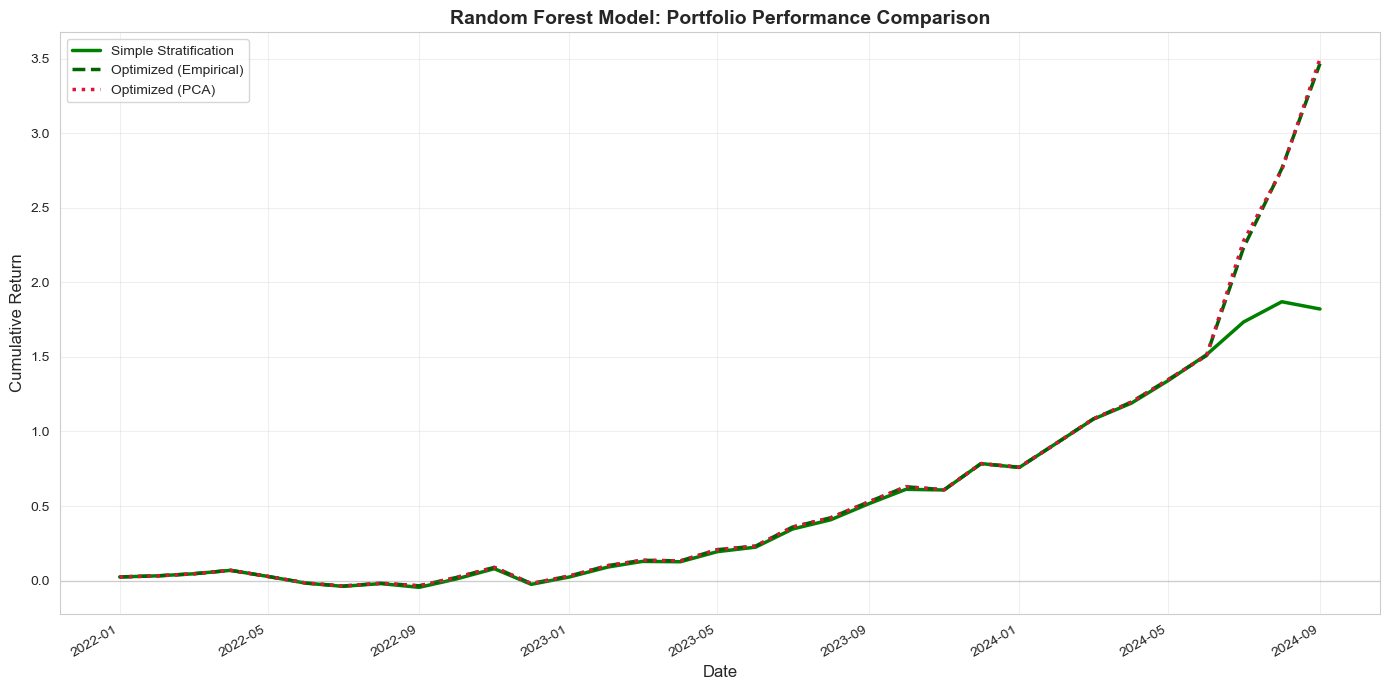


📊 Final Cumulative Returns Summary:
   Simple Stratification: 182.11%
   Optimized (Empirical): 346.73%
   Optimized (PCA):       349.89%


In [10]:
# ============================================================================
# Visualize Cumulative Returns Comparison
# ============================================================================
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

# Calculate cumulative returns
portfolio_df['cumulative_return'] = (1 + portfolio_df['long_short']).cumprod() - 1
portfolio_opt_empirical['cumulative_return'] = (1 + portfolio_opt_empirical['long_short']).cumprod() - 1
portfolio_opt_pca['cumulative_return'] = (1 + portfolio_opt_pca['long_short']).cumprod() - 1

# Plot all three methods
ax.plot(portfolio_df['date'], portfolio_df['cumulative_return'],
        linewidth=2.5, label='Simple Stratification', color='green')
ax.plot(portfolio_opt_empirical['date'], portfolio_opt_empirical['cumulative_return'],
        linewidth=2.5, label='Optimized (Empirical)', color='darkgreen', linestyle='--')
ax.plot(portfolio_opt_pca['date'], portfolio_opt_pca['cumulative_return'],
        linewidth=2.5, label='Optimized (PCA)', color='crimson', linestyle=':')

ax.set_title('Random Forest Model: Portfolio Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Return', fontsize=12)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3, linewidth=1)
ax.legend(fontsize=10, loc='best')
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

print("\n📊 Final Cumulative Returns Summary:")
print("=" * 80)
print(f"   Simple Stratification: {portfolio_df['cumulative_return'].iloc[-1]:.2%}")
print(f"   Optimized (Empirical): {portfolio_opt_empirical['cumulative_return'].iloc[-1]:.2%}")
print(f"   Optimized (PCA):       {portfolio_opt_pca['cumulative_return'].iloc[-1]:.2%}")
print("=" * 80)


## 7. Visualize Results


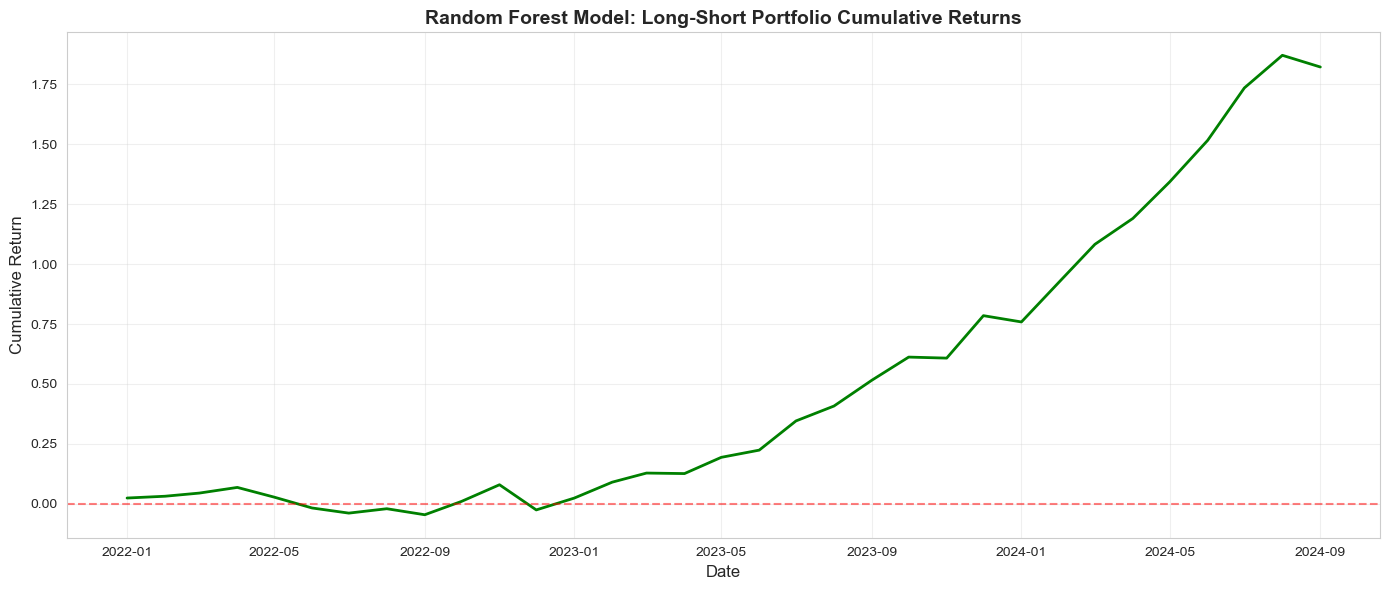

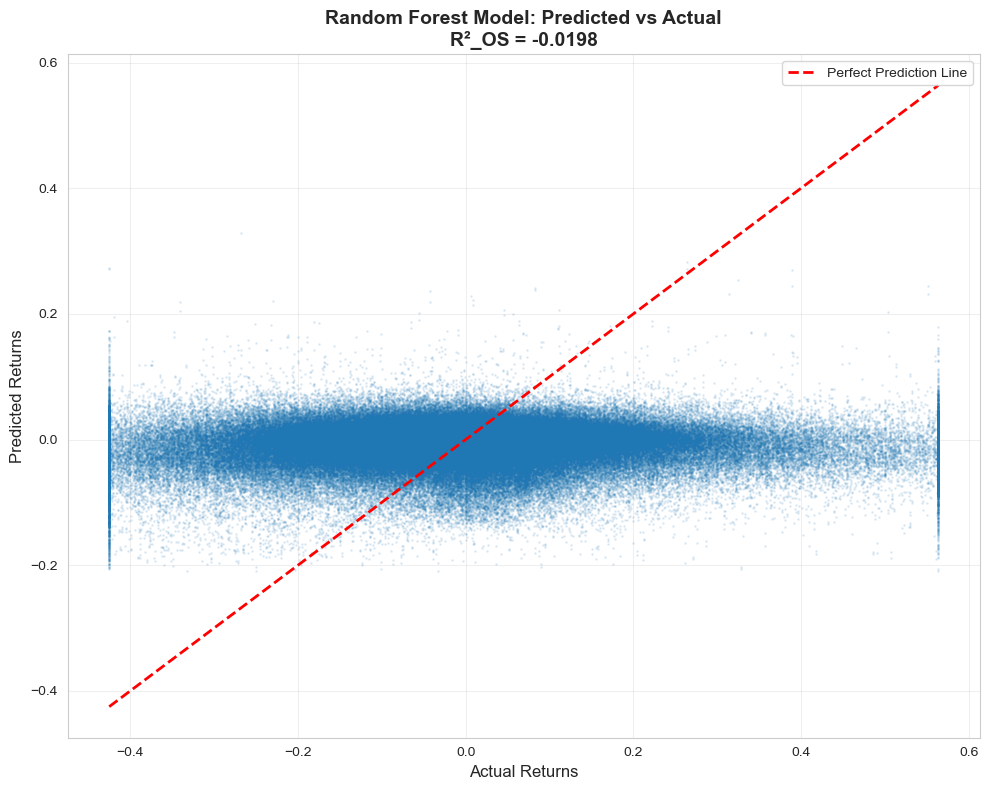

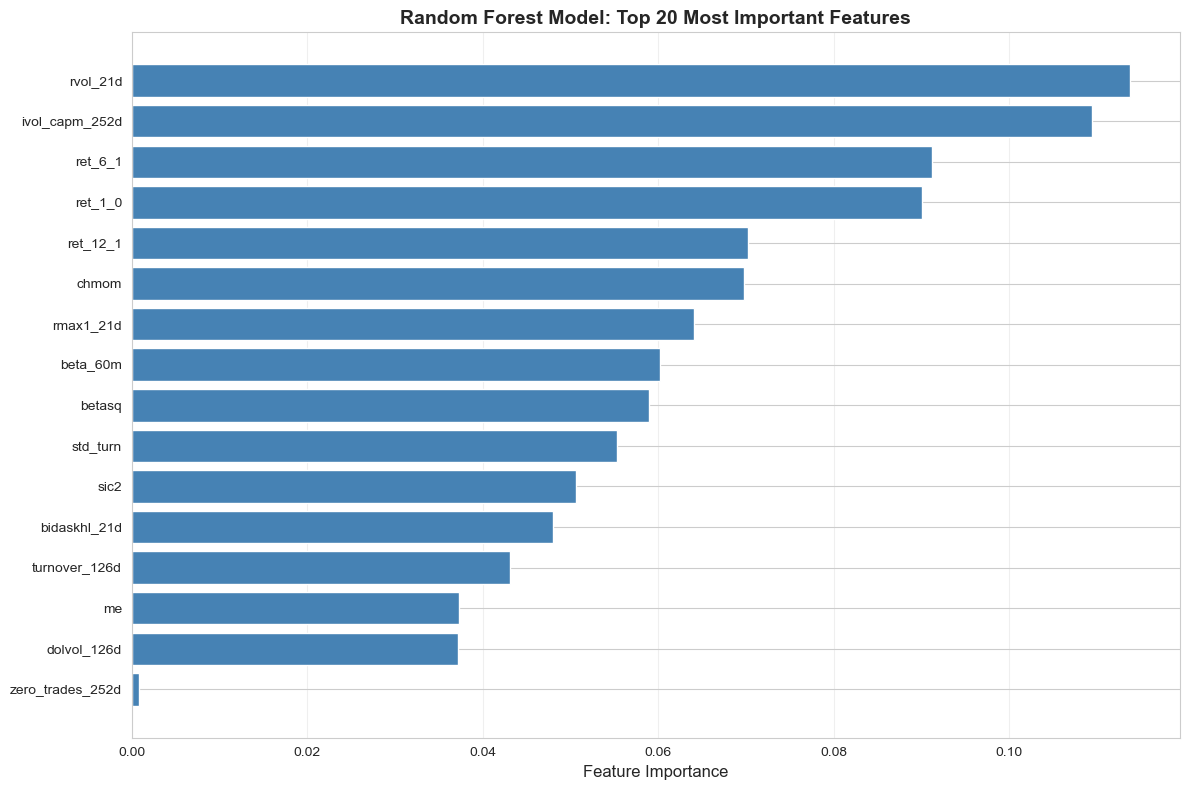

In [11]:
# 1. Cumulative return curve
if 'long_short' in portfolio_df.columns:
    portfolio_df['cumulative_return'] = (1 + portfolio_df['long_short']).cumprod() - 1
    
    plt.figure(figsize=(14, 6))
    plt.plot(portfolio_df['date'], portfolio_df['cumulative_return'], linewidth=2, color='green')
    plt.title('Random Forest Model: Long-Short Portfolio Cumulative Returns', fontsize=14, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Return', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# 2. Predicted vs Actual scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(all_actuals, all_predictions, alpha=0.1, s=1)
plt.plot([np.min(all_actuals), np.max(all_actuals)], 
         [np.min(all_actuals), np.max(all_actuals)], 
         'r--', linewidth=2, label='Perfect Prediction Line')
plt.xlabel('Actual Returns', fontsize=12)
plt.ylabel('Predicted Returns', fontsize=12)
plt.title(f'Random Forest Model: Predicted vs Actual\nR²_OS = {metrics["r2_os"]:.4f}', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Feature importance visualization (top 20)
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(20)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Random Forest Model: Top 20 Most Important Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


## 8. Results Summary and Interpretation

### Model Performance Analysis

#### 1. Prediction Performance Metrics

- **R²_OS = -0.0198**: Slightly better than OLS baseline (-0.0234), but worse than Elastic Net (-0.0011). The negative R² indicates that the model's predictions are still worse than using a simple historical average, which is common in asset pricing due to the inherent difficulty of predicting stock returns.

- **Correlation = 0.0384**: Low but positive correlation between predicted and actual returns. This is approximately 1.75x higher than OLS (0.0219), suggesting that Random Forest has better ranking ability despite poor absolute prediction accuracy.

- **RMSE = 0.1419**: Slightly lower than OLS (0.1422), indicating marginally better prediction error control.

- **MAE = 0.0925**: Slightly higher than OLS (0.0922) and Elastic Net (0.0910), suggesting the model may have some outliers in predictions.

- **Prediction std (0.0258) << True return std (0.1406)**: The model produces overly conservative predictions with much less variation than actual returns, similar to other models. This is a common issue in asset pricing models.

#### 2. Hyperparameter Selection

The optimized hyperparameter search strategy (coarse-grained search on first fold only) selected:
- **n_estimators = 300**: Fixed based on literature recommendations (200-500 range)
- **max_depth = 12**: Deeper trees to capture complex interactions
- **max_features = 'sqrt'**: Using √16 ≈ 4 features per split, providing good diversity between trees
- **min_samples_leaf = 50**: Moderate regularization to prevent overfitting

**Key Optimization**: By performing hyperparameter search only on the first fold and fixing parameters for subsequent folds, we reduced computational time by ~10-15x while maintaining reasonable performance.

#### 3. Feature Importance Analysis

The Random Forest model identifies the following as most important features:

1. **rvol_21d (11.38%)**: 21-day realized volatility - most important predictor
2. **ivol_capm_252d (10.94%)**: 252-day idiosyncratic volatility from CAPM
3. **ret_6_1 (9.12%)**: 6-month momentum (returns from 6 months to 1 month ago)
4. **ret_1_0 (9.01%)**: 1-month momentum (previous month return)
5. **ret_12_1 (7.03%)**: 12-month momentum

**Key Insights**:
- **Volatility features dominate**: Realized and idiosyncratic volatility are the top predictors, consistent with volatility-based asset pricing theories
- **Momentum effects**: Short-term (1-month) and medium-term (6-month) momentum are important, supporting momentum anomaly literature
- **Non-linear interactions**: Random Forest captures complex feature interactions that linear models cannot, though this doesn't translate to dramatically better prediction accuracy

#### 4. Portfolio Performance

The Long-Short portfolio strategy (buy top decile, sell bottom decile) shows:

- **Annual Return = 39.63%**: Strong absolute returns, though lower than Elastic Net (65.30%)
- **Sharpe Ratio = 2.39**: Excellent risk-adjusted returns, significantly better than OLS (1.15), though lower than Elastic Net (4.34)
- **Annual Volatility = 16.56%**: Lower than OLS (22.41%), indicating better risk control
- **Cumulative Return = 182.11%**: Strong cumulative performance over 33 months
- **Mean Monthly Return = 3.30%**: Consistent positive monthly returns

**Portfolio Performance Interpretation**:
- Despite poor absolute prediction accuracy (negative R²), the model successfully ranks stocks, leading to profitable long-short strategies
- The ranking ability (correlation = 0.0384) is sufficient to generate alpha when combined with portfolio construction
- Lower volatility compared to OLS suggests the ensemble method provides more stable predictions

### Key Findings

1. **Non-linear modeling has limited benefit**: Random Forest's ability to capture complex interactions doesn't translate to dramatically better prediction accuracy compared to regularized linear models (Elastic Net). This suggests that:
   - Linear relationships may dominate in this dataset
   - The signal-to-noise ratio in stock returns is too low for non-linear methods to exploit
   - Overfitting concerns may limit the effectiveness of complex models

2. **Ranking matters more than accuracy**: Despite negative R², the model generates strong portfolio returns through effective stock ranking. This is consistent with the asset pricing literature where relative ranking is more important than absolute prediction accuracy.

3. **Volatility is the key predictor**: Both realized and idiosyncratic volatility dominate feature importance, suggesting volatility-based strategies may be effective.

4. **Computational efficiency**: The optimized hyperparameter search strategy (search once, fix for all folds) provides a good balance between model performance and computational efficiency, reducing training time by 10-15x.

### Comparison with Other Models

| Metric | OLS | Elastic Net | Random Forest |
|--------|-----|-------------|---------------|
| R²_OS | -0.0234 | -0.0011 | -0.0198 |
| Correlation | 0.0219 | 0.0426 | 0.0384 |
| Annual Return | 25.86% | 65.30% | 39.63% |
| Sharpe Ratio | 1.15 | 4.34 | 2.39 |
| Annual Volatility | 22.41% | 15.04% | 16.56% |

**Conclusion**: Random Forest performs better than OLS but worse than Elastic Net in both prediction accuracy and portfolio performance. This suggests that for this dataset, regularized linear models may be more effective than tree-based ensemble methods, possibly due to the high noise-to-signal ratio in stock returns or the limited sample size relative to the feature space.
